In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Importo dataset

In [4]:
folder = '/Users/julianganzabal/.kaggle/competitions/jigsaw-toxic-comment-classification-challenge/'

In [5]:
train = pd.read_csv(folder+"train.csv")
test = pd.read_csv(folder+"test.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
submission = pd.read_csv(folder+"sample_submission.csv")

In [6]:
train[:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [8]:
y[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Divido entre train y valid

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

In [10]:
X_train.shape

(143613, 8)

In [11]:
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

In [12]:
print(raw_text_train[0:10]) # Recordar que train_test_split hace shuffle 

22418     list of premature obituaries \nthanks for your...
153244    eh? suggesting a propable motive is not accept...
52951     "\n\n reading order \ni have a copy of the ser...
49080     it could be in a another artical by itself. i ...
46162     that stuff about hadal was really funny. i bet...
144395                             @ me next time #subtweet
151962    wp:rm \nwhy are you removing my voiced support...
108547    yes, but soap boxing is appropriate as you hav...
27647     "\n\n gerry ouellette \n\nhi there, i took a l...
149098       you've probably already heard his messiah, but
Name: comment_text, dtype: object


In [13]:
Y_train[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Armo matriz de features

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 20

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=max_features,
                                   stop_words='english')

tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)

In [72]:
top_10 = np.argsort(tfidf_matrix_train.sum(axis=0))[0,::-1][0,:10].tolist()[0]

In [73]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())
feature_names[np.array(top_10)]

array(['article', 'talk', 'page', 'wikipedia', 'just', 'like', 'don',
       'think', 'know', 'thanks'],
      dtype='<U11')

In [74]:
dense_matrix_train = tfidf_matrix_train.todense()

In [75]:
dense_matrix_train.shape, Y_train.shape

((143613, 20), (143613, 6))

In [76]:
tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)

In [77]:
dense_matrix_valid = tfidf_matrix_valid.todense()

# Modelo de 1 capa densa

In [78]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers

In [79]:
input_features = dense_matrix_train.shape[1]
output_size = Y_train.shape[1]
hidden_units = 100
lambd = 0 #0.001
model_sig_nn = Sequential()
model_sig_nn.add(Dense(output_size,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.01 
batch_size = 1024
epochs = 4

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 6)                 126       
_________________________________________________________________
output (Activation)          (None, 6)                 0         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


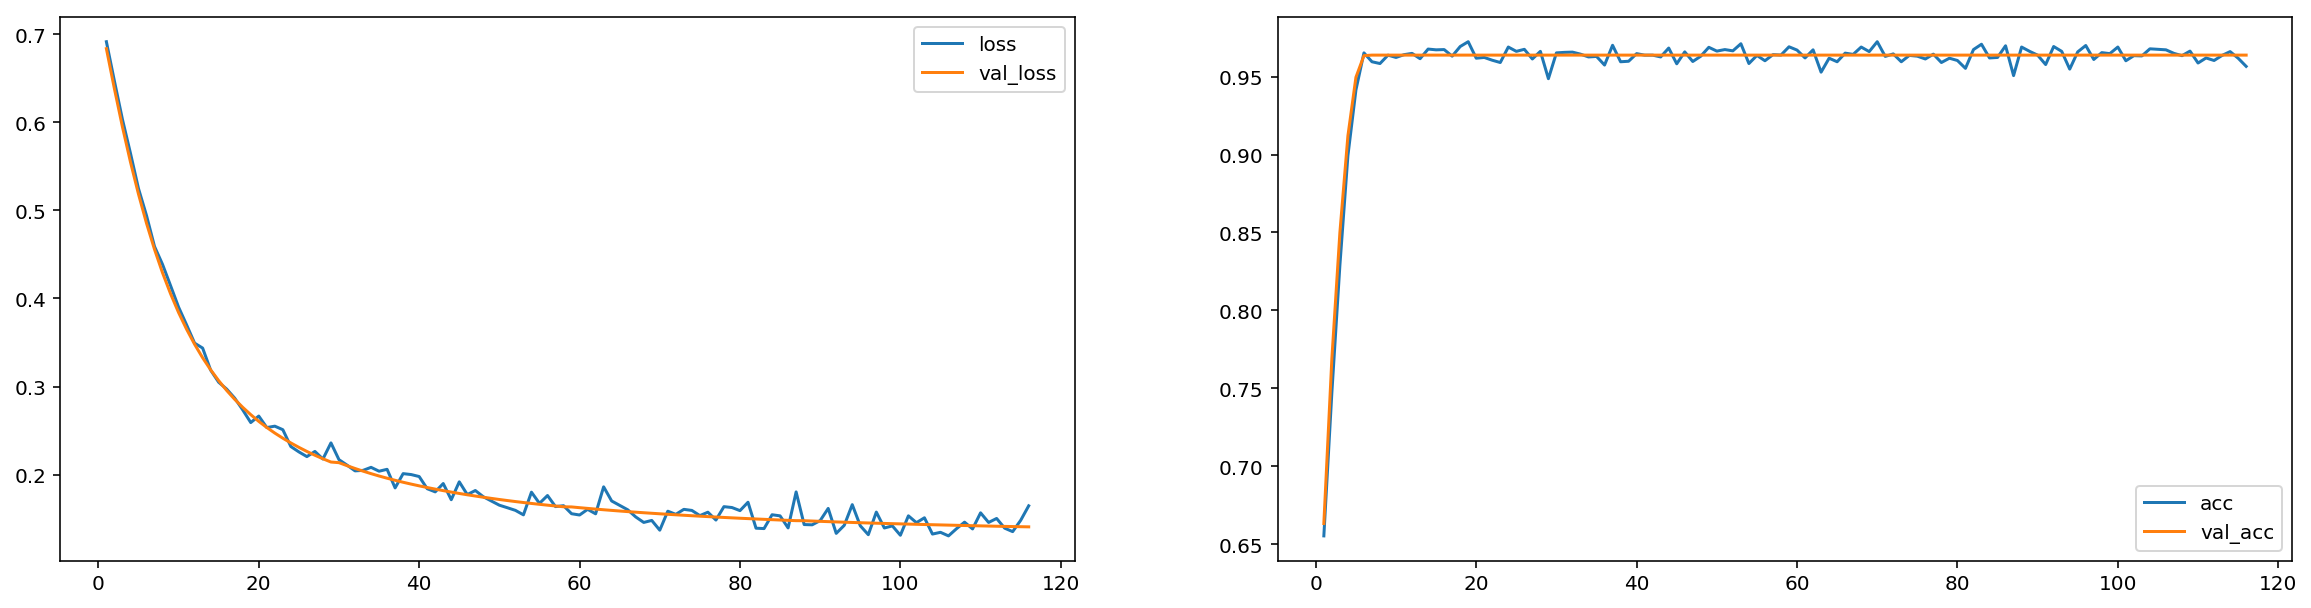

Epoch 00003: val_loss improved from 0.14775 to 0.14073, saving model to basic_model_best.hdf5
143613/143613 [==============================] - 10s - loss: 0.1457 - acc: 0.9633 - val_loss: 0.1407 - val_acc: 0.9637


In [80]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='basic_model_best.hdf5', verbose=1, save_best_only=True)

plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=5, 
                         x_val=dense_matrix_valid, 
                         y_val_categorical=Y_valid)
history = model_sig_nn.fit(dense_matrix_train, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(dense_matrix_valid, Y_valid), 
          callbacks=[plot_losses, checkpointer],
         )

# Evaluo valid

In [81]:
model_sig_nn.load_weights('basic_model_best.hdf5')

In [82]:
tfidf_matrix_valid.shape, Y_valid.shape

((15958, 20), (15958, 6))

In [83]:
pred_valid = model_sig_nn.predict(dense_matrix_valid, batch_size = 1024, verbose = 1)

 1024/15958 [>.............................] - ETA: 0s

In [84]:
model_sig_nn.evaluate(dense_matrix_valid, Y_valid)

15648/15958 [============================>.] - ETA: 0s

[0.14073148187609869, 0.96373814483351661]

# ROC Curve

In [85]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print(roc_auc_score(Y_valid, pred_valid))
print(roc_auc_score(Y_valid, 1*(pred_valid>0.5)))

0.686117526199
0.5


In [86]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

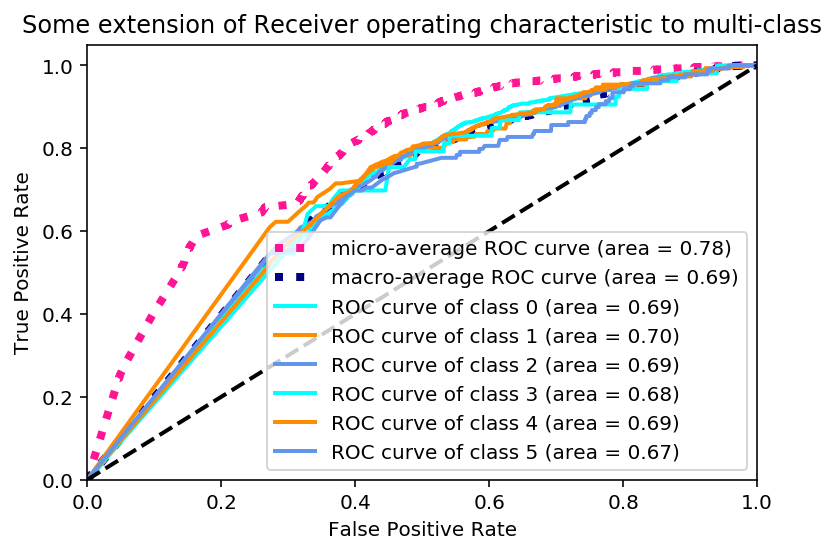

In [89]:
from matplotlib import pyplot as plt
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**True Positive Rate**:   
The number of times your system was able to classify the positives as positives. 

True positive rate = Correctly Classified Positives/(Correctly Classified as Positives+ Falsely Classified as Negatives)

**False Positive Rate**:  
The number of times your system classified a negative as a positive divided by the total  actual negative instances.


False positive rate = Incorrectly Classified as Positives/(Incorrectly Classified as Positives+ Correctly classified as Negatives )

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001

Macro-average: Calcula el score de cada clase y luego promedia  
Micro-average: Suma y luego calcula el score

Micro-average se considera mejor cuando hay desbalce en las clases

# Predict for test

In [36]:
tfidf_matrix_test = tfidf_vectorizer.transform(raw_text_test)

In [37]:
dense_matrix_test = tfidf_matrix_test.todense()

In [ ]:
pred = model_sig_nn.predict(dense_matrix_test, verbose=1)

In [ ]:
1*(pred[0:10]>0.5)

In [ ]:
submission[list_classes] = pred
submission.to_csv("submission_early_stop_2_epochs.csv", index = False)

Submit1 ROC AUC en valid = 0.731196488262  
Submit2 ROC AUC en valid = 0.963410980044  
Submit3 ROC AUC en valid = 0.974042855266

In [ ]:
# ~/.local/bin/kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission_early_stop_2_epochs.csv -m "Early stop 2 epochs"